In [299]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

DATA_PATH = "../ml-latest-small"

In [218]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))

movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [219]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [220]:
# Espansione dei generi in colonne binarie
movies_with_genres = movies_df.copy()
movies_with_genres['genres'] = movies_with_genres['genres'].str.split('|')

movies_with_genres.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [221]:
from collections import Counter

# Sostituisci '(no genres listed)' con una stringa unica per evitare problemi durante la separazione
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', 'No_genres_listed')

# Crea una lista di tutti i generi
all_genres = '|'.join(movies_df['genres']).split('|')

# Conta le occorrenze di ciascun genere
genre_counts = Counter(all_genres)

# Crea un DataFrame a partire dal contatore
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

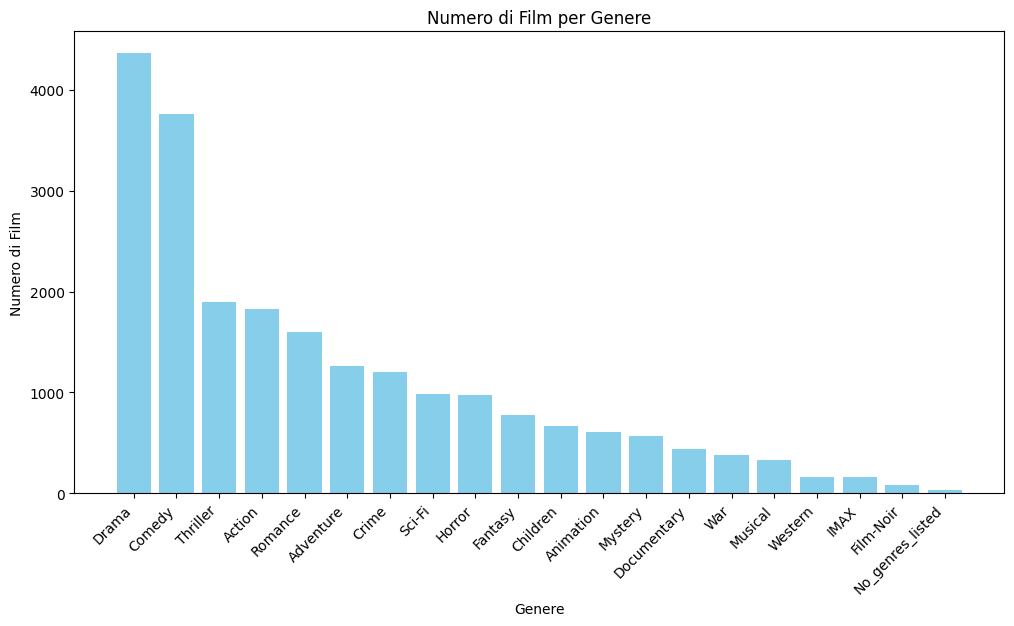

In [222]:
# Crea il grafico a barre
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Genere')
plt.ylabel('Numero di Film')
plt.title('Numero di Film per Genere')
plt.xticks(rotation=45, ha='right')
plt.show()

In [223]:
# Estrai tutti i generi unici
all_genres = set()
for genres in movies_df['genres']:
    all_genres.update(genres.split('|'))

# Sicome dopo calcolo one-hot encoding, devo tenere questa colonna nel dizionario ma la vorrei per ultima (quindi tolgo e poi la riaggiungo dopo aver creato dizionario)
all_genres.remove('No_genres_listed')

# Crea un dizionario: nome_genere -> indice
genre_dict = {genre: idx for idx, genre in enumerate(sorted(all_genres), 1)}

genre_dict["No_genres_listed"] = len(all_genres)+1

print("Dizionario generi:", genre_dict)

Dizionario generi: {'Action': 1, 'Adventure': 2, 'Animation': 3, 'Children': 4, 'Comedy': 5, 'Crime': 6, 'Documentary': 7, 'Drama': 8, 'Fantasy': 9, 'Film-Noir': 10, 'Horror': 11, 'IMAX': 12, 'Musical': 13, 'Mystery': 14, 'Romance': 15, 'Sci-Fi': 16, 'Thriller': 17, 'War': 18, 'Western': 19, 'No_genres_listed': 20}


In [224]:
# Crea colonne binarie per i generi
genre_onehot = movies_df['genres'].str.get_dummies(sep='|')

# Moltiplica ogni colonna per il suo indice (1 diventa l'indice, 0 resta 0)
genre_encoded = genre_onehot.copy()
for genre in genre_encoded.columns:
    genre_encoded[genre] = genre_encoded[genre] * genre_dict[genre]

# Combina con movieId e title
movies_encoded = pd.concat([movies_df[['movieId', 'title']], genre_encoded], axis=1)

movies_encoded = movies_encoded.drop("No_genres_listed", axis=1)

movies_encoded.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,2,3,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,15,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,5,0,0,8,...,0,0,0,0,0,15,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Inserimento dei Tags

In [225]:
tags_df = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [226]:
# Combinare i tag per ogni film
tags_per_movie = tags_df.groupby('movieId')['tag']
# Creo tutti i tags univoci
tags_per_movie = tags_per_movie.apply(lambda x: ' '.join(set(x))).reset_index()

# Uniamo i tag combinati al dataframe dei film
movies_with_tags = pd.merge(movies_encoded, tags_per_movie, on='movieId', how='left')

# Gestiamo eventuali NaN nei tag (se un film non ha tag, mettiamo una stringa vuota)
movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')

movies_with_tags.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
0,1,Toy Story (1995),0,2,3,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,pixar fun
1,2,Jumanji (1995),0,2,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,game fantasy magic board game Robin Williams
2,3,Grumpier Old Men (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,15,0,0,0,0,old moldy
3,4,Waiting to Exhale (1995),0,0,0,0,5,0,0,8,...,0,0,0,0,15,0,0,0,0,
4,5,Father of the Bride Part II (1995),0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,pregnancy remake


## Suggerimento Modello da chat

qui ha già fatto un classificatore basato su TF-IDF (metrica che prende parole e pesa sia rarità che n° occorrenze) per valutare similarità tra due film.

Io integrerei anche la parte di categoria da usare sia assieme che in caso di mancanza di tags (due film con tag vuoti saranno molto simili, almeno vediamo categorie) per trovare modello generale

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Creiamo il vettore TF-IDF sui tag
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_with_tags['tag'])

# Calcoliamo la similarità del coseno tra i film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Funzione per ottenere raccomandazioni basate sui tag
def get_movie_recommendations(movie_id, cosine_sim=cosine_sim, top_n=10):
    # Ottieni l'indice del film
    idx = movies_with_tags.index[movies_with_tags['movieId'] == movie_id].tolist()[0]

    # Ottieni la lista delle similarità per il film richiesto
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordina i film in base alla similarità e ottieni i top_n film simili
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Ottieni gli ID dei film consigliati
    movie_indices = [i[0] for i in sim_scores]

    # Restituisci i film consigliati
    recommended_movies = movies_with_tags[['movieId', 'title', 'tag']].iloc[movie_indices]
    return recommended_movies

# Esempio: ottenere raccomandazioni per il film con ID 1
recommended_movies = get_movie_recommendations(movie_id=1)
recommended_movies

,movieId,title,tag
1757,2355,"Bug's Life, A (1998)",Pixar
8695,122918,Guardians of the Galaxy 2 (2017),fun
2355,3114,Toy Story 2 (1999),Pixar Disney original Tom Hanks animation funn...
8546,115617,Big Hero 6 (2014),robots fun family movie very funny animation k...
8357,108932,The Lego Movie (2014),colorful fun imaginative cheeky feel-good quir...
7693,89745,"Avengers, The (2012)",superhero team fun silly Captain America super...
7039,68954,Up (2009),computer animation dreams Pixar divorce Bechde...
257,296,Pulp Fiction (1994),Palme d'Or film-noir dancing gore offensive ki...
1,2,Jumanji (1995),game fantasy magic board game Robin Williams
2,3,Grumpier Old Men (1995),old moldy


## 1. Naive Bayes Content-based Recommender System

The model is trained on metadata including the movie title and genres, with titles cleaned to remove release years.

In [302]:
# metadata available for each movie
metadata = movies_with_genres.copy()
metadata.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


Removing the year from movie titles helps clean the data for content-based recommendation. The year adds no semantic value for models using text features like TF-IDF and can introduce noise or inflate the vocabulary. By focusing on the actual title, we ensure better feature extraction and more accurate similarity comparisons between movies.

In [303]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)

In [304]:
metadata['title'] = metadata['title'].apply(clean_title)

In [305]:
metadata.head()

,movieId,title,genres
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men,"[Comedy, Romance]"
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,[Comedy]


## Binarize the genres

Binarizing genres turns categorical data into a binary format, making it easier for machine learning models to process. This method helps handle movies with multiple genres and captures interactions between them, improving recommendation accuracy. It simplifies the feature engineering process and ensures the model can effectively learn from genre information.

In [306]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'])

In [307]:
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
genres_df.drop(columns=['(no genres listed)'], inplace=True)

In [308]:
genres_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [309]:
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)

In [310]:
metadata.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [276]:
# Create binary target: Recommended (rating >= 3), Not Recommended (rating < 3)
ratings_df['target'] = ratings_df['rating'].apply(lambda x: 1 if x >= 3 else 0)

In [279]:
# ratings_df.drop(columns=['timestamp'], inplace=True)

In [278]:
ratings_df.head()

,userId,movieId,rating,target
0,1,1,4.0,1
1,1,3,4.0,1
2,1,6,4.0,1
3,1,47,5.0,1
4,1,50,5.0,1


In [311]:
# Merge ratings with metadata to include target label
data = ratings_df.merge(metadata, on='movieId')

In [312]:
data.head()

,userId,movieId,rating,target,title,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,1,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,1,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,0,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [313]:
X = data.drop(columns=['userId', 'rating', 'target'])  # drop irrelevant columns
y = data['target']


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

In [314]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'title'),
                                                 ('genres', 'passthrough',
                                                  Index(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object'))])),
                ('classifier', MultinomialNB())])

In [315]:
def recommend_movies(user_id, pipeline, top_k=10):
    """
    Recommend top K movies to a given user based on metadata using a trained Naive Bayes content-based model.

    Parameters:
        user_id (int): ID of the user for whom recommendations are to be made.
        pipeline (sklearn.Pipeline): Trained pipeline with preprocessing and Naive Bayes model.
        top_k (int): Number of top recommendations to return.

    Returns:
        pd.DataFrame: Top recommended movies for the user.
    """
    # Get movies already rated by the user
    user_movies = ratings_df[ratings_df['userId'] == user_id]
    
    # Filter out movies the user has already rated
    unrated_movies = movies_encoded[~movies_encoded['movieId'].isin(user_movies['movieId'])].copy()

    # Prepare feature columns (must match training)
    input_cols = list(X.columns)  # X used during training

    # Predict probabilities (likelihood the user will like the movie)
    predictions = pipeline.predict_proba(unrated_movies[input_cols])[:, 1]

    # Add prediction scores
    unrated_movies['recommendation_score'] = predictions

    # Sort by score and return top-k
    recommended = unrated_movies.sort_values(by='recommendation_score', ascending=False)
    
    return recommended[['title', 'recommendation_score']].head(top_k)

In [316]:
recommendations = recommend_movies(
    user_id=35,
    pipeline=pipeline,
    top_k=5
)

print(recommendations)

                                                  title  recommendation_score
6826                 Waltz with Bashir (Vals im Bashir)                   1.0
6345            Shooting Dogs (a.k.a. Beyond the Gates)                   1.0
5443                 Night and Fog (Nuit et brouillard)                   1.0
5640  Joint Security Area (Gongdong gyeongbi guyeok ...                   1.0
4922                                          The Alamo                   1.0


# Evaluate the model

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])


pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'title')])),
                ('classifier', MultinomialNB())])

Accuracy: 0.5443276477588259


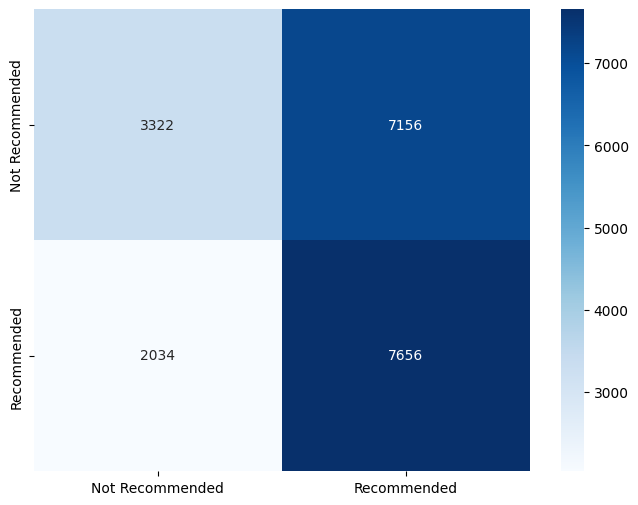

In [317]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
print("Accuracy:", accuracy_score(y_test, y_pred))

**Using just basic features like title and genre may not be enough to make accurate recommendations, especially if the users' preferences are influenced by more factors like movie descriptions, actors...**

## 2.

In [247]:
from sklearn.naive_bayes import MultinomialNB

# merge of ratings_df and tags_per_movie 
data = pd.merge(ratings_df, tags_per_movie, on='movieId')
data = data.dropna(subset=['tag'])

# Labeling the data, 1 for positive (rating >= 4), 0 for negative (rating <= 2) and None for neutral
data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
data = data.dropna(subset=['label'])
data['label'] = data['label'].astype(int)

# Create a TF-IDF vectorizer and transform the tags
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(data['tag'])
y = data['label']

# Train a logistic regression model
model = MultinomialNB()
model.fit(X, y)

# Function to recommend movies for a user
def recommend_for_user(user_id, top_n=10):
    user_seen = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    unseen_movies = tags_per_movie[~tags_per_movie['movieId'].isin(user_seen)].dropna()

    unseen_features = tfidf.transform(unseen_movies['tag'])
    probs = model.predict_proba(unseen_features)[:, 1]
    unseen_movies['score'] = probs

    unseen_movies = unseen_movies.merge(movies_df[['movieId', 'title']], on='movieId')

    return unseen_movies.sort_values('score', ascending=False).head(top_n)[['movieId', 'title', 'score']]

# Example: recommend movies for user with ID 1
recommendations = recommend_for_user(user_id=2)
print(recommendations)

      movieId                                              title     score
637      2959                                  Fight Club (1999)  0.995075
93        356                                Forrest Gump (1994)  0.988718
286      1193             One Flew Over the Cuckoo's Nest (1975)  0.986116
1145     7361       Eternal Sunshine of the Spotless Mind (2004)  0.984874
330      1258                                Shining, The (1980)  0.984502
289      1198  Raiders of the Lost Ark (Indiana Jones and the...  0.984490
537      2329                          American History X (1998)  0.984175
76        293  Léon: The Professional (a.k.a. The Professiona...  0.983666
72        280                         Murder in the First (1995)  0.983653
341      1276                              Cool Hand Luke (1967)  0.983653
